<a href="https://colab.research.google.com/github/irenedini/learning-fastai/blob/main/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 194kB 53.0MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 1.0MB 57.8MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 40kB 7.4MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 2.6MB 57.0MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

In [3]:
path = untar_data(URLs.ML_100k)

In [4]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u.user'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/u5.base'),Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/ua.base')...]

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, 
                      names=['User', 'Movie', 'Rating', 'Timestamp'])

ratings.head()

,User,Movie,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', 
                     usecols=(0,1), header=None, names=('Movie', 'Title'))

movies.head()

,Movie,Title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
ratings = ratings.merge(movies)

ratings.head()

,User,Movie,Rating,Timestamp,Title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='Title', bs=64)

dls.show_batch()

,User,Title,Rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [9]:
learner = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=1.9054607491852948e-06)

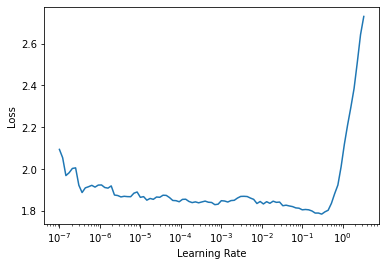

In [10]:
learner.lr_find()

In [11]:
learner.fit_one_cycle(5, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.238526,1.230687,00:09
1,1.256746,1.244428,00:09
2,1.042467,1.032976,00:09
3,0.812740,0.873431,00:09
4,0.544234,0.857120,00:09


In [12]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [13]:
# "best" movies and "worst" movies according to model bias

movie_bias = learner.model.i_bias.weight.data
movie_bias_list = [movie_bias[i].item() for i in range(len(movie_bias))]
sorted_indices = np.array(movie_bias_list).argsort()

worst_movies = [dls.classes['Title'][i] for i in sorted_indices[:5]]
best_movies = list(reversed([dls.classes['Title'][i] 
                             for i in (sorted_indices[-5:])]))

worst_movies, best_movies

(['Children of the Corn: The Gathering (1996)',
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  'Mortal Kombat: Annihilation (1997)',
  'Spice World (1997)',
  'Bio-Dome (1996)'],
 ['Shawshank Redemption, The (1994)',
  'Star Wars (1977)',
  'Casablanca (1942)',
  "Schindler's List (1993)",
  'Good Will Hunting (1997)'])

In [26]:
class CollabNN(Module):
    def __init__(self, user_dim, movie_dim, n_act=100, y_range=(0, 5.5)):
        self.user_factors = Embedding(*user_dim)
        self.movie_factors = Embedding(*movie_dim)
        self.layers = nn.Sequential(
            nn.Linear(user_dim[1]+movie_dim[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        self.y_range = y_range
    
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.movie_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [27]:
embedding_dims = get_emb_sz(dls)
embedding_dims

[(944, 74), (1665, 102)]

In [28]:
model = CollabNN(*embedding_dims)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=6.309573450380412e-07)

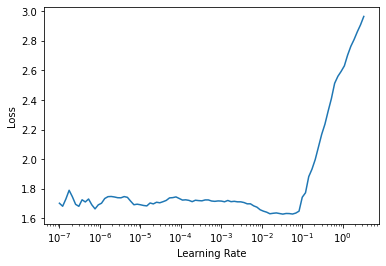

In [32]:
learner_2 = Learner(dls, model, loss_func=MSELossFlat())
learner_2.lr_find()

In [35]:
learner_2.fit_one_cycle(7, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.850948,0.883088,00:10
1,0.889693,0.883500,00:10
2,0.830417,0.874282,00:10
3,0.826656,0.857440,00:10
4,0.758745,0.849849,00:10
5,0.754061,0.850570,00:10
6,0.689074,0.854674,00:10


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=9.12010818865383e-07)

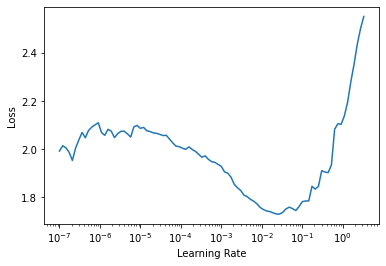

In [40]:
learner_3 = collab_learner(dls, y_range=(0, 5.5), use_nn=True, layers=[100])
learner_3.lr_find()

In [41]:
learner_3.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=176, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (2): SigmoidRange(low=0, high=5.5)
  )
)

In [42]:
learner_3.fit_one_cycle(5, 2e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.959676,0.982663,00:10
1,0.875108,0.911521,00:10
2,0.825319,0.859834,00:10
3,0.765532,0.853726,00:10
4,0.651460,0.860419,00:10
